C:\Users\charl\Projects\Monte Carlo Simulations\UFC_MC_Simulator.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['Method'] = filtered_df2['Method'].apply(lambda x: x.strip())
C:\Users\charl\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\charl\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

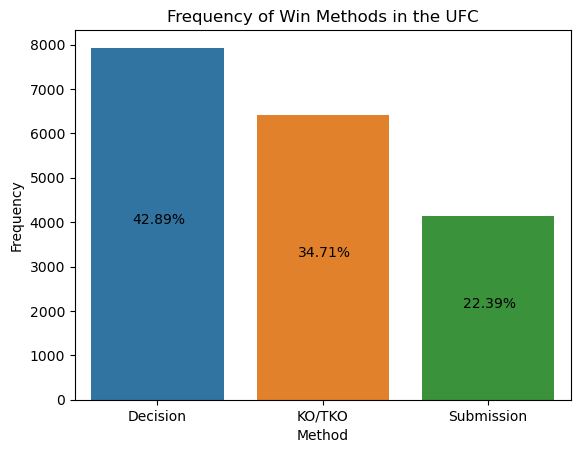

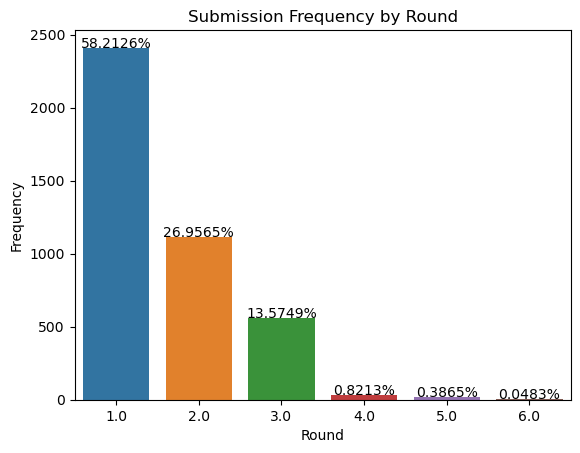

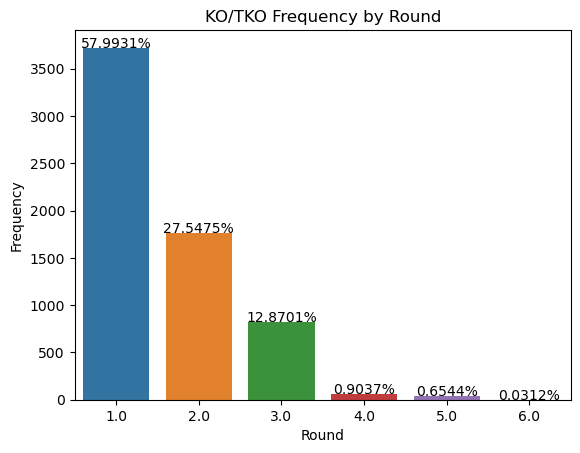

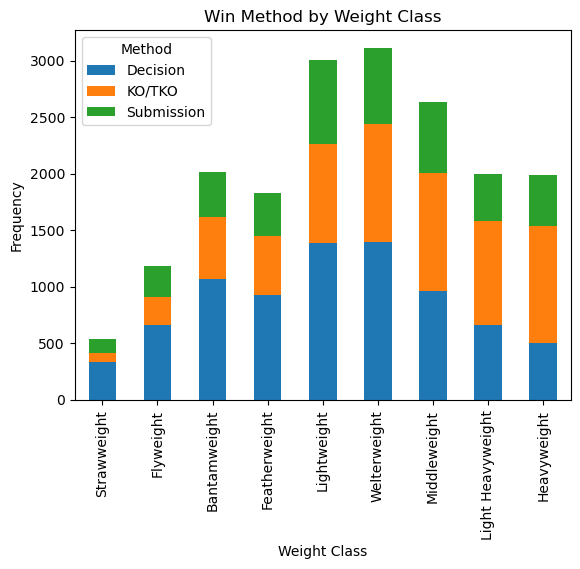

                     Decision      KO/TKO Submission
Strawweight         33100.00%    8200.00%  12200.00%
Flyweight           66100.00%   25000.00%  27200.00%
Bantamweight       107100.00%   54700.00%  39500.00%
Featherweight       92900.00%   51800.00%  38000.00%
Lightweight        138700.00%   87500.00%  74200.00%
Welterweight       139900.00%  104000.00%  67600.00%
Middleweight        96300.00%  104700.00%  62100.00%
Light Heavyweight   66100.00%   92200.00%  41100.00%
Heavyweight         50100.00%  103800.00%  44800.00%


In [1]:
from UFC_MC_Simulator import *

## Predictions on UFC Fight Night: Pavlovich vs Blaydes

### Sergei Pavlovich vs Curtis Blaydes

In [2]:
matchup_df = get_fighter_parameters("Sergei Pavlovich", "Curtis Blaydes")
matchesSim(matchup_df, 10000)

╒══════════════════╤══════════════╤═══════════════╕
│ Fighter          │ Win Method   │ Probability   │
╞══════════════════╪══════════════╪═══════════════╡
│ Sergei Pavlovich │ Decision     │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ Sergei Pavlovich │ KO           │ 92.88%        │
├──────────────────┼──────────────┼───────────────┤
│ Sergei Pavlovich │ Submission   │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ Curtis Blaydes   │ Decision     │ 0.02%         │
├──────────────────┼──────────────┼───────────────┤
│ Curtis Blaydes   │ KO           │ 7.1%          │
├──────────────────┼──────────────┼───────────────┤
│ Curtis Blaydes   │ Submission   │ 0.0%          │
╘══════════════════╧══════════════╧═══════════════╛


Actual Outcome: Sergei Pavlovich KO

Score: Perfect

### Brad Tavares vs Bruno Silva

In [279]:
matchup_df = get_fighter_parameters("Brad Tavares", "Bruno Blindado Silva")
matchesSim(matchup_df, 10000)

╒══════════════════════╤══════════════╤═══════════════╕
│ Fighter              │ Win Method   │ Probability   │
╞══════════════════════╪══════════════╪═══════════════╡
│ Brad Tavares         │ Decision     │ 53.53%        │
├──────────────────────┼──────────────┼───────────────┤
│ Brad Tavares         │ KO           │ 0.0%          │
├──────────────────────┼──────────────┼───────────────┤
│ Brad Tavares         │ Submission   │ 0.27%         │
├──────────────────────┼──────────────┼───────────────┤
│ Bruno Blindado Silva │ Decision     │ 0.01%         │
├──────────────────────┼──────────────┼───────────────┤
│ Bruno Blindado Silva │ KO           │ 46.19%        │
├──────────────────────┼──────────────┼───────────────┤
│ Bruno Blindado Silva │ Submission   │ 0.0%          │
╘══════════════════════╧══════════════╧═══════════════╛


Actual Outcome: Bruno Blindado Silva KO
    
Score: Winner incorrect, 2nd option correct

### Bobby Green vs Jared Gordon - No Contest

In [280]:
#matchup_df = get_fighter_parameters("Bobby Green", "Jared Gordon")
#gamesSim(10000)

### Iasmin Lucindo vs Brogan Walker

In [281]:
matchup_df = get_fighter_parameters("Iasmin Lucindo", "Brogan Walker")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Iasmin Lucindo │ Decision     │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Iasmin Lucindo │ KO           │ 100.0%        │
├────────────────┼──────────────┼───────────────┤
│ Iasmin Lucindo │ Submission   │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Brogan Walker  │ Decision     │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Brogan Walker  │ KO           │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Brogan Walker  │ Submission   │ 0.0%          │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Iasmin Lucindo Decision

Score: Winner correct, method wrong

### Jeremiah Wells vs Matthew Semelsberger

In [282]:
matchup_df = get_fighter_parameters("Jeremiah Wells", "Matthew Semelsberger")
matchesSim(matchup_df, 10000)

╒══════════════════════╤══════════════╤═══════════════╕
│ Fighter              │ Win Method   │ Probability   │
╞══════════════════════╪══════════════╪═══════════════╡
│ Jeremiah Wells       │ Decision     │ 3.68%         │
├──────────────────────┼──────────────┼───────────────┤
│ Jeremiah Wells       │ KO           │ 63.77%        │
├──────────────────────┼──────────────┼───────────────┤
│ Jeremiah Wells       │ Submission   │ 13.49%        │
├──────────────────────┼──────────────┼───────────────┤
│ Matthew Semelsberger │ Decision     │ 14.92%        │
├──────────────────────┼──────────────┼───────────────┤
│ Matthew Semelsberger │ KO           │ 4.14%         │
├──────────────────────┼──────────────┼───────────────┤
│ Matthew Semelsberger │ Submission   │ 0.0%          │
╘══════════════════════╧══════════════╧═══════════════╛


Actual Outcome: Jeremiah Wells Decision

Score: Winner correct, method wrong

### Rick Glenn vs Christos Giagos

In [283]:
matchup_df = get_fighter_parameters("Ricky Glenn", "Christos Giagos")
matchesSim(matchup_df, 10000)

╒═════════════════╤══════════════╤═══════════════╕
│ Fighter         │ Win Method   │ Probability   │
╞═════════════════╪══════════════╪═══════════════╡
│ Ricky Glenn     │ Decision     │ 37.63%        │
├─────────────────┼──────────────┼───────────────┤
│ Ricky Glenn     │ KO           │ 0.99%         │
├─────────────────┼──────────────┼───────────────┤
│ Ricky Glenn     │ Submission   │ 1.07%         │
├─────────────────┼──────────────┼───────────────┤
│ Christos Giagos │ Decision     │ 60.16%        │
├─────────────────┼──────────────┼───────────────┤
│ Christos Giagos │ KO           │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Christos Giagos │ Submission   │ 0.15%         │
╘═════════════════╧══════════════╧═══════════════╛


Actual Outcome: Christos Giagos KO

Score: Winner correct, method wrong

### Rani Yahya vs Montel Jackson

In [284]:
matchup_df = get_fighter_parameters("Rani Yahya", "Montel Jackson")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Rani Yahya     │ Decision     │ 15.9%         │
├────────────────┼──────────────┼───────────────┤
│ Rani Yahya     │ KO           │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Rani Yahya     │ Submission   │ 7.86%         │
├────────────────┼──────────────┼───────────────┤
│ Montel Jackson │ Decision     │ 75.2%         │
├────────────────┼──────────────┼───────────────┤
│ Montel Jackson │ KO           │ 1.04%         │
├────────────────┼──────────────┼───────────────┤
│ Montel Jackson │ Submission   │ 0.0%          │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Montel Jackson KO 

Score: Winner correct, method wrong

### Karol Rosa vs Norma Dumont

In [285]:
matchup_df = get_fighter_parameters("Karol Rosa", "Norma Dumont")
matchesSim(matchup_df, 10000)

╒══════════════╤══════════════╤═══════════════╕
│ Fighter      │ Win Method   │ Probability   │
╞══════════════╪══════════════╪═══════════════╡
│ Karol Rosa   │ Decision     │ 69.48%        │
├──────────────┼──────────────┼───────────────┤
│ Karol Rosa   │ KO           │ 0.01%         │
├──────────────┼──────────────┼───────────────┤
│ Karol Rosa   │ Submission   │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Norma Dumont │ Decision     │ 30.51%        │
├──────────────┼──────────────┼───────────────┤
│ Norma Dumont │ KO           │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Norma Dumont │ Submission   │ 0.0%          │
╘══════════════╧══════════════╧═══════════════╛


Actual Outcome: Norma Dumont Decision

Score: Winner incorrect, 2nd option correct

### Mohammed Usman vs Junior Tafa - N/A (Junior Tafa's first fight recorded on fightmetric)

### Francis Marshall vs William Gomis

In [286]:
matchup_df = get_fighter_parameters("Francis Marshall", "William Gomis")
matchesSim(matchup_df, 10000)

╒══════════════════╤══════════════╤═══════════════╕
│ Fighter          │ Win Method   │ Probability   │
╞══════════════════╪══════════════╪═══════════════╡
│ Francis Marshall │ Decision     │ 7.42%         │
├──────────────────┼──────────────┼───────────────┤
│ Francis Marshall │ KO           │ 8.01%         │
├──────────────────┼──────────────┼───────────────┤
│ Francis Marshall │ Submission   │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ William Gomis    │ Decision     │ 84.57%        │
├──────────────────┼──────────────┼───────────────┤
│ William Gomis    │ KO           │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ William Gomis    │ Submission   │ 0.0%          │
╘══════════════════╧══════════════╧═══════════════╛


Actual Outcome: William Gomis Decision

Score: Perfect

### Brady Hiestand vs Batgerel Danaa

In [287]:
matchup_df = get_fighter_parameters("Brady Hiestand", "Batgerel Danaa")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Brady Hiestand │ Decision     │ 65.25%        │
├────────────────┼──────────────┼───────────────┤
│ Brady Hiestand │ KO           │ 0.26%         │
├────────────────┼──────────────┼───────────────┤
│ Brady Hiestand │ Submission   │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Batgerel Danaa │ Decision     │ 20.06%        │
├────────────────┼──────────────┼───────────────┤
│ Batgerel Danaa │ KO           │ 14.43%        │
├────────────────┼──────────────┼───────────────┤
│ Batgerel Danaa │ Submission   │ 0.0%          │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Brady Danaa KO

Score: Winner correct, method wrong

### Final prediction scores for UFC Fight Night: Pavlovich vs Blaydes

Perfect: 2/9 

If 2nd outcome is accepted: 4/9 

Winner Only: 7/9 

## Predictions on UFC Fight Night: Song vs Simón

### Song Yadong vs Ricky Simón

In [289]:
matchup_df = get_fighter_parameters("Song Yadong", "Ricky Simon")
matchesSim(matchup_df, 10000) 

╒═════════════╤══════════════╤═══════════════╕
│ Fighter     │ Win Method   │ Probability   │
╞═════════════╪══════════════╪═══════════════╡
│ Song Yadong │ Decision     │ 13.85%        │
├─────────────┼──────────────┼───────────────┤
│ Song Yadong │ KO           │ 32.73%        │
├─────────────┼──────────────┼───────────────┤
│ Song Yadong │ Submission   │ 0.03%         │
├─────────────┼──────────────┼───────────────┤
│ Ricky Simon │ Decision     │ 50.6%         │
├─────────────┼──────────────┼───────────────┤
│ Ricky Simon │ KO           │ 0.45%         │
├─────────────┼──────────────┼───────────────┤
│ Ricky Simon │ Submission   │ 2.34%         │
╘═════════════╧══════════════╧═══════════════╛


Actual Outcome: Song Yadong KO

Score: Winner incorrect, 2nd option correct

### Caio Borralho vs Michal Oleksiejczuk

In [290]:
matchup_df = get_fighter_parameters("Caio Borralho", "Michal Oleksiejczuk")
matchesSim(matchup_df, 10000)

╒═════════════════════╤══════════════╤═══════════════╕
│ Fighter             │ Win Method   │ Probability   │
╞═════════════════════╪══════════════╪═══════════════╡
│ Caio Borralho       │ Decision     │ 91.0%         │
├─────────────────────┼──────────────┼───────────────┤
│ Caio Borralho       │ KO           │ 0.2%          │
├─────────────────────┼──────────────┼───────────────┤
│ Caio Borralho       │ Submission   │ 0.06%         │
├─────────────────────┼──────────────┼───────────────┤
│ Michal Oleksiejczuk │ Decision     │ 0.0%          │
├─────────────────────┼──────────────┼───────────────┤
│ Michal Oleksiejczuk │ KO           │ 8.74%         │
├─────────────────────┼──────────────┼───────────────┤
│ Michal Oleksiejczuk │ Submission   │ 0.0%          │
╘═════════════════════╧══════════════╧═══════════════╛


Actual Outcome: Caio Borralho Submission

Score: Winner correct, method wrong

### Rodolfo Vieira vs Cody Brundage

In [291]:
matchup_df = get_fighter_parameters("Rodolfo Vieira", "Cody Brundage")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Rodolfo Vieira │ Decision     │ 2.42%         │
├────────────────┼──────────────┼───────────────┤
│ Rodolfo Vieira │ KO           │ 17.97%        │
├────────────────┼──────────────┼───────────────┤
│ Rodolfo Vieira │ Submission   │ 55.38%        │
├────────────────┼──────────────┼───────────────┤
│ Cody Brundage  │ Decision     │ 2.01%         │
├────────────────┼──────────────┼───────────────┤
│ Cody Brundage  │ KO           │ 2.02%         │
├────────────────┼──────────────┼───────────────┤
│ Cody Brundage  │ Submission   │ 20.2%         │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Rodolfo Vieira Submission

Score: Perfect

### Julian Erosa vs Fernando Padilla - N/A (Fernando Padilla's first fight recorded on fightmetric)

### Marcos Rogério de Lima vs Waldo Cortes-Acosta

In [292]:
matchup_df = get_fighter_parameters("Marcos Rogerio de Lima", "Cody Brundage")
matchesSim(matchup_df, 10000)

╒════════════════════════╤══════════════╤═══════════════╕
│ Fighter                │ Win Method   │ Probability   │
╞════════════════════════╪══════════════╪═══════════════╡
│ Marcos Rogerio de Lima │ Decision     │ 5.52%         │
├────────────────────────┼──────────────┼───────────────┤
│ Marcos Rogerio de Lima │ KO           │ 68.81%        │
├────────────────────────┼──────────────┼───────────────┤
│ Marcos Rogerio de Lima │ Submission   │ 0.02%         │
├────────────────────────┼──────────────┼───────────────┤
│ Cody Brundage          │ Decision     │ 0.02%         │
├────────────────────────┼──────────────┼───────────────┤
│ Cody Brundage          │ KO           │ 1.44%         │
├────────────────────────┼──────────────┼───────────────┤
│ Cody Brundage          │ Submission   │ 24.19%        │
╘════════════════════════╧══════════════╧═══════════════╛


Actual Outcome: Marcos Rogerio de Lima Decision

Score: Winner correct, method wrong

### Josh Quinlan vs Trey Waters

In [293]:
matchup_df = get_fighter_parameters("Josh Quinlan", "Trey Waters")
matchesSim(matchup_df, 10000)

╒══════════════╤══════════════╤═══════════════╕
│ Fighter      │ Win Method   │ Probability   │
╞══════════════╪══════════════╪═══════════════╡
│ Josh Quinlan │ Decision     │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Josh Quinlan │ KO           │ 100.0%        │
├──────────────┼──────────────┼───────────────┤
│ Josh Quinlan │ Submission   │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Trey Waters  │ Decision     │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Trey Waters  │ KO           │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Trey Waters  │ Submission   │ 0.0%          │
╘══════════════╧══════════════╧═══════════════╛


Actual Outcome: Trey Waters Decision

Score: All incorrect 

### Martin Buday vs Jake Collier

In [294]:
matchup_df = get_fighter_parameters("Martin Buday", "Jake Collier")
matchesSim(matchup_df, 10000)

╒══════════════╤══════════════╤═══════════════╕
│ Fighter      │ Win Method   │ Probability   │
╞══════════════╪══════════════╪═══════════════╡
│ Martin Buday │ Decision     │ 71.28%        │
├──────────────┼──────────────┼───────────────┤
│ Martin Buday │ KO           │ 28.37%        │
├──────────────┼──────────────┼───────────────┤
│ Martin Buday │ Submission   │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Jake Collier │ Decision     │ 0.35%         │
├──────────────┼──────────────┼───────────────┤
│ Jake Collier │ KO           │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Jake Collier │ Submission   │ 0.0%          │
╘══════════════╧══════════════╧═══════════════╛


Actual Outcome: Martin Buday Decision

Score: Perfect

### Cody Durden vs Charles Johnson

In [295]:
matchup_df = get_fighter_parameters("Cody Durden", "Charles Johnson")
matchesSim(matchup_df, 10000)

╒═════════════════╤══════════════╤═══════════════╕
│ Fighter         │ Win Method   │ Probability   │
╞═════════════════╪══════════════╪═══════════════╡
│ Cody Durden     │ Decision     │ 85.18%        │
├─────────────────┼──────────────┼───────────────┤
│ Cody Durden     │ KO           │ 0.89%         │
├─────────────────┼──────────────┼───────────────┤
│ Cody Durden     │ Submission   │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Charles Johnson │ Decision     │ 2.64%         │
├─────────────────┼──────────────┼───────────────┤
│ Charles Johnson │ KO           │ 2.9%          │
├─────────────────┼──────────────┼───────────────┤
│ Charles Johnson │ Submission   │ 8.39%         │
╘═════════════════╧══════════════╧═══════════════╛


Actual Outcome: Cody Durden Decision

Score: Perfect

### Final prediction scores for UFC Fight Night: Song vs Simón

Perfect: 3/7 

If 2nd outcome is accepted: 4/7

Winner only: 5/7

### Stephanie Egger vs Irina Alekseeva - N/A (Irina Alekseeva first fight recorded on fightmetric)

### Journey Newson vs Marcus McGhee - N/A (Marcus McGhee first fight recorded on fightmetric)

### Hailey Cowan vs Jamey-Lyn Horth - N/A (Jamey-Lyn Horth first fight recorded on fightmetric)

## Predictions on UFC 288: Sterling vs. Cejudo

### Aljamain Sterling vs Henry Cejudo

In [297]:
matchup_df = get_fighter_parameters("Aljamain Sterling", "Henry Cejudo")
matchesSim(matchup_df, 10000)

╒═══════════════════╤══════════════╤═══════════════╕
│ Fighter           │ Win Method   │ Probability   │
╞═══════════════════╪══════════════╪═══════════════╡
│ Aljamain Sterling │ Decision     │ 28.46%        │
├───────────────────┼──────────────┼───────────────┤
│ Aljamain Sterling │ KO           │ 0.28%         │
├───────────────────┼──────────────┼───────────────┤
│ Aljamain Sterling │ Submission   │ 0.36%         │
├───────────────────┼──────────────┼───────────────┤
│ Henry Cejudo      │ Decision     │ 62.48%        │
├───────────────────┼──────────────┼───────────────┤
│ Henry Cejudo      │ KO           │ 8.42%         │
├───────────────────┼──────────────┼───────────────┤
│ Henry Cejudo      │ Submission   │ 0.0%          │
╘═══════════════════╧══════════════╧═══════════════╛


Actual Outcome: Aljamain Sterling Decision

Score: Winner incorrect, 2nd option correct

### Belal Muhammad vs Gilbert Burns

In [298]:
matchup_df = get_fighter_parameters("Belal Muhammad", "Gilbert Burns")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Belal Muhammad │ Decision     │ 93.17%        │
├────────────────┼──────────────┼───────────────┤
│ Belal Muhammad │ KO           │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Belal Muhammad │ Submission   │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Gilbert Burns  │ Decision     │ 6.77%         │
├────────────────┼──────────────┼───────────────┤
│ Gilbert Burns  │ KO           │ 0.01%         │
├────────────────┼──────────────┼───────────────┤
│ Gilbert Burns  │ Submission   │ 0.05%         │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Belal Muhammad Decision

Score: Perfect

### Jessica Andrade vs Yan Xiaonan

In [299]:
matchup_df = get_fighter_parameters("Jessica Andrade", "Yan Xiaonan")
matchesSim(matchup_df, 10000)

╒═════════════════╤══════════════╤═══════════════╕
│ Fighter         │ Win Method   │ Probability   │
╞═════════════════╪══════════════╪═══════════════╡
│ Jessica Andrade │ Decision     │ 1.34%         │
├─────────────────┼──────────────┼───────────────┤
│ Jessica Andrade │ KO           │ 0.35%         │
├─────────────────┼──────────────┼───────────────┤
│ Jessica Andrade │ Submission   │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Yan Xiaonan     │ Decision     │ 98.31%        │
├─────────────────┼──────────────┼───────────────┤
│ Yan Xiaonan     │ KO           │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Yan Xiaonan     │ Submission   │ 0.0%          │
╘═════════════════╧══════════════╧═══════════════╛


Actual Outcome: Yan Xiaonan KO

Score: Winner correct, method wrong

### Movsar Evloev vs Bryce Mitchell

In [300]:
matchup_df = get_fighter_parameters("Movsar Evloev", "Bryce Mitchell")
matchesSim(matchup_df, 10000)

╒════════════════╤══════════════╤═══════════════╕
│ Fighter        │ Win Method   │ Probability   │
╞════════════════╪══════════════╪═══════════════╡
│ Movsar Evloev  │ Decision     │ 95.3%         │
├────────────────┼──────────────┼───────────────┤
│ Movsar Evloev  │ KO           │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Movsar Evloev  │ Submission   │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Bryce Mitchell │ Decision     │ 4.7%          │
├────────────────┼──────────────┼───────────────┤
│ Bryce Mitchell │ KO           │ 0.0%          │
├────────────────┼──────────────┼───────────────┤
│ Bryce Mitchell │ Submission   │ 0.0%          │
╘════════════════╧══════════════╧═══════════════╛


Actual Outcome: Movsar Evloev Decision

Score: Perfect

### Kron Gracie vs Charles Jourdain

In [313]:
matchup_df = get_fighter_parameters("Kron Gracie", "Charles Jourdain")
matchesSim(matchup_df, 10000)

╒══════════════════╤══════════════╤═══════════════╕
│ Fighter          │ Win Method   │ Probability   │
╞══════════════════╪══════════════╪═══════════════╡
│ Kron Gracie      │ Decision     │ 12.72%        │
├──────────────────┼──────────────┼───────────────┤
│ Kron Gracie      │ KO           │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ Kron Gracie      │ Submission   │ 43.01%        │
├──────────────────┼──────────────┼───────────────┤
│ Charles Jourdain │ Decision     │ 43.12%        │
├──────────────────┼──────────────┼───────────────┤
│ Charles Jourdain │ KO           │ 1.05%         │
├──────────────────┼──────────────┼───────────────┤
│ Charles Jourdain │ Submission   │ 0.1%          │
╘══════════════════╧══════════════╧═══════════════╛


Actual Outcome: Charles Jourdain Decision

Score: perfect

### Drew Dober vs Matt Frevola

In [302]:
matchup_df = get_fighter_parameters("Drew Dober", "Matt Frevola")
matchesSim(matchup_df, 10000)

╒══════════════╤══════════════╤═══════════════╕
│ Fighter      │ Win Method   │ Probability   │
╞══════════════╪══════════════╪═══════════════╡
│ Drew Dober   │ Decision     │ 1.91%         │
├──────────────┼──────────────┼───────────────┤
│ Drew Dober   │ KO           │ 82.77%        │
├──────────────┼──────────────┼───────────────┤
│ Drew Dober   │ Submission   │ 0.0%          │
├──────────────┼──────────────┼───────────────┤
│ Matt Frevola │ Decision     │ 10.21%        │
├──────────────┼──────────────┼───────────────┤
│ Matt Frevola │ KO           │ 1.68%         │
├──────────────┼──────────────┼───────────────┤
│ Matt Frevola │ Submission   │ 3.43%         │
╘══════════════╧══════════════╧═══════════════╛


Actual Outcome: Matt Frevola KO

Score: All incorrect

### Kennedy Nzechukwu vs Devin Clark

In [303]:
matchup_df = get_fighter_parameters("Kennedy Nzechukwu", "Devin Clark")
matchesSim(matchup_df, 10000)

╒═══════════════════╤══════════════╤═══════════════╕
│ Fighter           │ Win Method   │ Probability   │
╞═══════════════════╪══════════════╪═══════════════╡
│ Kennedy Nzechukwu │ Decision     │ 0.89%         │
├───────────────────┼──────────────┼───────────────┤
│ Kennedy Nzechukwu │ KO           │ 69.5%         │
├───────────────────┼──────────────┼───────────────┤
│ Kennedy Nzechukwu │ Submission   │ 0.1%          │
├───────────────────┼──────────────┼───────────────┤
│ Devin Clark       │ Decision     │ 29.45%        │
├───────────────────┼──────────────┼───────────────┤
│ Devin Clark       │ KO           │ 0.06%         │
├───────────────────┼──────────────┼───────────────┤
│ Devin Clark       │ Submission   │ 0.0%          │
╘═══════════════════╧══════════════╧═══════════════╛


Actual Outcome: Kennedy Nzechukwu Submission

Score: Winner correct, method wrong

### Khaos Williams vs Rolando Bedoya - N/A (Rolando Bedoya first fight recorded on fightmetric)

### Marina Rodriguez vs Virna Jandiroba

In [304]:
matchup_df = get_fighter_parameters("Marina Rodriguez", "Virna Jandiroba")
matchesSim(matchup_df, 10000)

╒══════════════════╤══════════════╤═══════════════╕
│ Fighter          │ Win Method   │ Probability   │
╞══════════════════╪══════════════╪═══════════════╡
│ Marina Rodriguez │ Decision     │ 98.1%         │
├──────────────────┼──────────────┼───────────────┤
│ Marina Rodriguez │ KO           │ 0.15%         │
├──────────────────┼──────────────┼───────────────┤
│ Marina Rodriguez │ Submission   │ 0.0%          │
├──────────────────┼──────────────┼───────────────┤
│ Virna Jandiroba  │ Decision     │ 0.46%         │
├──────────────────┼──────────────┼───────────────┤
│ Virna Jandiroba  │ KO           │ 0.54%         │
├──────────────────┼──────────────┼───────────────┤
│ Virna Jandiroba  │ Submission   │ 0.75%         │
╘══════════════════╧══════════════╧═══════════════╛


Actual Outcome: Virna Jandiroba Decision

Score: All incorrect

### Braxton Smith vs Parker Porter - N/A (Braxton Smith first fight recorded on fightmetric)

### Phil Hawes vs Ikram Aliskerov

In [305]:
matchup_df = get_fighter_parameters("Phil Hawes", "Ikram Aliskerov")
matchesSim(matchup_df, 10000)

╒═════════════════╤══════════════╤═══════════════╕
│ Fighter         │ Win Method   │ Probability   │
╞═════════════════╪══════════════╪═══════════════╡
│ Phil Hawes      │ Decision     │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Phil Hawes      │ KO           │ 0.01%         │
├─────────────────┼──────────────┼───────────────┤
│ Phil Hawes      │ Submission   │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Ikram Aliskerov │ Decision     │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Ikram Aliskerov │ KO           │ 0.01%         │
├─────────────────┼──────────────┼───────────────┤
│ Ikram Aliskerov │ Submission   │ 99.98%        │
╘═════════════════╧══════════════╧═══════════════╛


Actual Outcome: Ikram Aliskerov KO

Score: Winner correct, method wrong

### Rafael Estevam vs Zhalgas Zhumagulov - Cancelled

### Joseph Holmes vs Claudio Ribeiro

In [306]:
matchup_df = get_fighter_parameters("Joseph Holmes", "Claudio Ribeiro")
matchesSim(matchup_df, 10000)

╒═════════════════╤══════════════╤═══════════════╕
│ Fighter         │ Win Method   │ Probability   │
╞═════════════════╪══════════════╪═══════════════╡
│ Joseph Holmes   │ Decision     │ 0.0%          │
├─────────────────┼──────────────┼───────────────┤
│ Joseph Holmes   │ KO           │ 32.23%        │
├─────────────────┼──────────────┼───────────────┤
│ Joseph Holmes   │ Submission   │ 26.53%        │
├─────────────────┼──────────────┼───────────────┤
│ Claudio Ribeiro │ Decision     │ 4.53%         │
├─────────────────┼──────────────┼───────────────┤
│ Claudio Ribeiro │ KO           │ 32.25%        │
├─────────────────┼──────────────┼───────────────┤
│ Claudio Ribeiro │ Submission   │ 4.46%         │
╘═════════════════╧══════════════╧═══════════════╛


Actual Outcome: Claudio Ribeiro KO

Score: Perfect

### Daniel Santos vs Johnny Munoz - Cancelled

### Final prediction scores for UFC 288: Sterling vs Cejudo

Perfect: 4/10

If 2nd outcome is accepted: 5/10

Winner only: 7/10